100%|██████████| 9.91M/9.91M [00:02<00:00, 4.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.02MB/s]


Epoch 1/10, Batch 0, Loss: 543.0428
Epoch 1/10, Batch 100, Loss: 191.7280
Epoch 1/10, Batch 200, Loss: 188.9035
Epoch 1/10, Batch 300, Loss: 171.2724
Epoch 1/10, Batch 400, Loss: 167.6346
Epoch 1/10, Average Loss: 192.8084
Epoch 2/10, Batch 0, Loss: 153.7404
Epoch 2/10, Batch 100, Loss: 148.7046
Epoch 2/10, Batch 200, Loss: 138.3406
Epoch 2/10, Batch 300, Loss: 134.2333
Epoch 2/10, Batch 400, Loss: 132.1703
Epoch 2/10, Average Loss: 141.3525
Epoch 3/10, Batch 0, Loss: 132.0196
Epoch 3/10, Batch 100, Loss: 128.5583
Epoch 3/10, Batch 200, Loss: 129.5202
Epoch 3/10, Batch 300, Loss: 122.2549
Epoch 3/10, Batch 400, Loss: 122.1205
Epoch 3/10, Average Loss: 126.3391
Epoch 4/10, Batch 0, Loss: 119.8179
Epoch 4/10, Batch 100, Loss: 119.6461
Epoch 4/10, Batch 200, Loss: 118.0441
Epoch 4/10, Batch 300, Loss: 115.8309
Epoch 4/10, Batch 400, Loss: 118.1625
Epoch 4/10, Average Loss: 119.2360
Epoch 5/10, Batch 0, Loss: 116.1866
Epoch 5/10, Batch 100, Loss: 115.1247
Epoch 5/10, Batch 200, Loss: 112.7

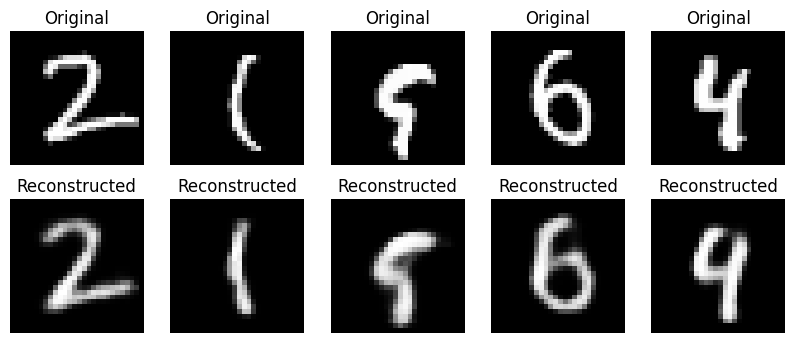

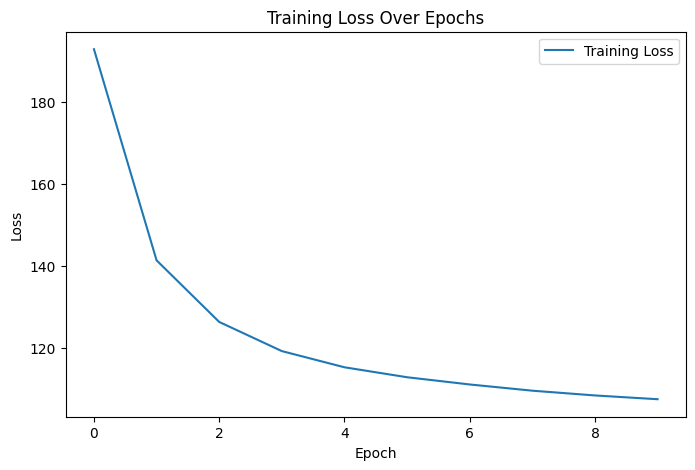

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_dim = 784  # MNIST images: 28x28
hidden_dim = 256
latent_dim = 32
batch_size = 128
epochs = 10
lr = 0.001
beta = 0.1  # Weight for cycle consistency loss

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Recognition Model (Bottom-up: Context -> Latent)
class RecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RecognitionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim * 2)  # Outputs mean and log-variance
        )

    def forward(self, x):
        params = self.encoder(x)
        mu, logvar = params[:, :latent_dim], params[:, latent_dim:]
        return mu, logvar

# Generative Model (Top-down: Latent -> Content)
class GenerativeModel(nn.Module):
    def __init__(self, latent_dim, hidden_dim, input_dim):
        super(GenerativeModel, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.decoder(z)

# Helmholtz Machine with Cycle Consistency
class HelmholtzMachine(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(HelmholtzMachine, self).__init__()
        self.recognition = RecognitionModel(input_dim, hidden_dim, latent_dim)
        self.generative = GenerativeModel(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Bottom-up: Recognition (Context -> Latent)
        mu, logvar = self.recognition(x)
        z = self.reparameterize(mu, logvar)

        # Top-down: Generation (Latent -> Content)
        x_recon = self.generative(z)

        # Inverted inference: Re-encode reconstructed data (Cycle consistency)
        mu_recon, logvar_recon = self.recognition(x_recon)
        z_recon = self.reparameterize(mu_recon, logvar_recon)

        return x_recon, mu, logvar, z, mu_recon, logvar_recon

# Loss function: Reconstruction + KL Divergence + Cycle Consistency
def loss_function(x, x_recon, mu, logvar, mu_recon, logvar_recon, beta):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')

    # KL Divergence for variational inference
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cycle consistency loss: Encourage z_recon to match z
    cycle_loss = nn.functional.mse_loss(mu_recon, mu)

    return recon_loss + kl_loss + beta * cycle_loss

# Training function
def train(model, train_loader, optimizer, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            x_recon, mu, logvar, z, mu_recon, logvar_recon = model(data)
            loss = loss_function(data, x_recon, mu, logvar, mu_recon, logvar_recon, beta)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item()/len(data):.4f}')

        avg_loss = total_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

    return losses

# Visualization function
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(data_loader))
        data = data.to(device)
        x_recon, _, _, _, _, _ = model(data)
        data = data.cpu().numpy().reshape(-1, 28, 28)
        x_recon = x_recon.cpu().numpy().reshape(-1, 28, 28)

        plt.figure(figsize=(10, 4))
        for i in range(5):
            plt.subplot(2, 5, i + 1)
            plt.imshow(data[i], cmap='gray')
            plt.title('Original')
            plt.axis('off')
            plt.subplot(2, 5, i + 6)
            plt.imshow(x_recon[i], cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.show()

# Initialize model, optimizer, and train
model = HelmholtzMachine(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = train(model, train_loader, optimizer, epochs)

# Visualize results
visualize_reconstruction(model, train_loader)

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()